In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import copy
import os
from datetime import datetime

In [99]:
df = pd.DataFrame([]) # 데이터프레임 만들기
df = pd.read_csv('../data/Data_Final_SeqDone.csv') 

df['Code'] = df['Code'].astype('category')

df['Date_Time'] = pd.to_datetime(df['Date_Time'].str.strip(), format="%Y-%m-%d %H:%M:%S", errors="raise")

df.head()

,Code,Blood_Glucose,Patient_ID,Code_Description,Date_Time
0,58,101.0,31,PRE_BREAKFAST,1991-05-20 08:00:00
1,33,5.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00
2,34,27.0,31,NPH_INSULIN_DOSE,1991-05-20 08:00:00
3,60,89.0,31,PRE_LUNCH,1991-05-20 12:00:00
4,33,3.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00


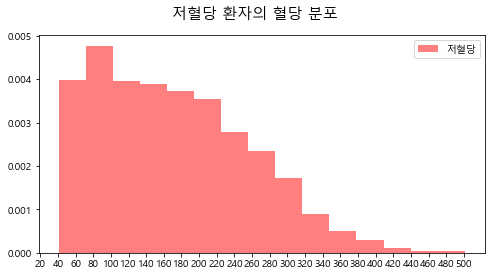

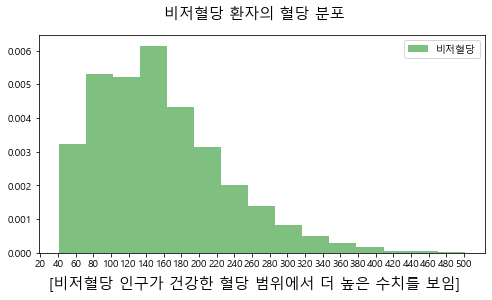

In [100]:
plt.rc("font", family="Malgun Gothic") # 한글 출력 적용

fig = plt.gcf()
plt.suptitle('저혈당 환자의 혈당 분포', fontsize=15)
fig.set_size_inches(8, 4, forward=True)
df['Hypo_Flag'] = False
df.loc[df['Patient_ID'].isin(df.loc[df['Code_Description'] == 'HYPOGLYCEMIC_SYMPTOMS', 'Patient_ID'].unique()),'Hypo_Flag'] = True 
#저혈당 증상이 있는 환자 flag true 설정

plt.hist(df.loc[(df['Hypo_Flag']==True) & (df['Blood_Glucose']>40),'Blood_Glucose'], bins=15, alpha=0.5, color='r', density=True, label='저혈당')
# 저혈당 히스토그램

plt.legend()
plt.xticks(range(20,int(df['Blood_Glucose'].max()),20))
plt.show()

fig = plt.gcf()
plt.suptitle('비저혈당 환자의 혈당 분포', fontsize=15)
fig.set_size_inches(8, 4, forward=True)

plt.hist(df.loc[(df['Hypo_Flag']==False) & (df['Blood_Glucose']>40),'Blood_Glucose'], bins=15, alpha=0.5, color='g',density=True, label='비저혈당')
# 비저혈당 히스토그램

fig.text(0.5,0, '[비저혈당 인구가 건강한 혈당 범위에서 더 높은 수치를 보임]' ,
         horizontalalignment='center',
         verticalalignment='baseline',
         size=15)

plt.legend()
plt.xticks(range(20,int(df['Blood_Glucose'].max()),20))
plt.show()


In [101]:
### 다양한 외부 요인들을 시각화 하기 위한 데이터프레임 생성
group_df = df.groupby('Patient_ID')

df_agg = pd.DataFrame({
    'mean' : group_df['Blood_Glucose'].mean(),
    'median' : group_df['Blood_Glucose'].median(),
    'std' : group_df['Blood_Glucose'].std(),
    
    'highs_perday' : group_df.apply(lambda group : group[group['Blood_Glucose']>180]['Blood_Glucose'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    
    'lows_perday' : group_df.apply(lambda group : group[group['Blood_Glucose']<60]['Blood_Glucose'].count()
                                   /(group.Date_Time.max() - group.Date_Time.min()).days),
    
    'hypos_perday' : group_df.apply(
        lambda group : group[group['Code_Description']=='HYPOGLYCEMIC_SYMPTOMS']['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    
    'exercise_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='TYPICAL_EXERCISE') |
                            (group['Code_Description']=='LESS_EXERCISE') |
                            (group['Code_Description']=='MORE_EXERCISE')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    
    'irregular_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='LESS_EXERCISE') |
                            (group['Code_Description']=='MORE_EXERCISE') |
                            (group['Code_Description']=='MORE_MEAL_INJESTION') |
                            (group['Code_Description']=='LESS_MEAL_INJESTION')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    
    'readings_perday' : group_df['Date_Time'].apply(lambda group : group.count()
                                                /((group.max() - group.min()).days)),
    
    'snacks_perday' : group_df.apply(lambda group : group[group['Code_Description']=='PRE_SNACK']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    
    'regular_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='REGULAR_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    
    'nph_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='NPH_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    
    'ultralente_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='ULTRALENTE_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    
    'insulin_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='REGULAR_INSULIN_DOSE') |
                            (group['Code_Description']=='NPH_INSULIN_DOSE') |
                            (group['Code_Description']=='ULTRALENTE_INSULIN_DOSE')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days))
})

df_agg.head()

,mean,median,std,highs_perday,lows_perday,hypos_perday,exercise_perday,irregular_perday,readings_perday,snacks_perday,regular_insulin_perday,nph_insulin_perday,ultralente_insulin_perday,insulin_perday
Patient_ID,,,,,,,,,,,,,,
1,67.783333,15.0,85.840507,0.970370,4.103704,0.362963,0.0,0.000000,6.666667,0.000000,2.703704,0.970370,0.000000,3.674074
2,100.045205,17.0,105.922854,2.084211,4.042105,0.000000,0.0,0.000000,7.684211,0.000000,3.905263,0.021053,0.000000,3.926316
3,70.313793,9.0,80.270788,0.894737,4.184211,0.078947,0.0,0.263158,7.631579,0.394737,1.552632,0.026316,1.842105,3.421053
4,82.479310,9.0,96.339767,1.578947,4.131579,0.026316,0.0,0.157895,7.631579,0.842105,1.789474,1.421053,0.473684,3.684211
5,85.882759,9.5,98.199818,1.425000,3.900000,0.000000,0.0,0.050000,7.250000,0.900000,1.725000,1.875000,0.000000,3.600000


In [102]:
df_agg_plot = df_agg.reset_index().drop('Patient_ID', axis = 'columns') # 안 쓸 인덱스 정리

df_agg_plot['Hypo_Flag'] = 'Non_Hypoglycemic'
df_agg_plot.loc[df_agg_plot['hypos_perday']>0.0, 'Hypo_Flag'] = 'Hypoglycemic'

df_agg_plot = pd.melt(df_agg_plot, id_vars=['Hypo_Flag'], var_name='params') # 데이터프레임을 간단하게 재구조화

df_agg_plot.tail(5)

,Hypo_Flag,params,value
975,Hypoglycemic,insulin_perday,3.894737
976,Hypoglycemic,insulin_perday,3.815126
977,Non_Hypoglycemic,insulin_perday,0.564460
978,Non_Hypoglycemic,insulin_perday,0.000000
979,Non_Hypoglycemic,insulin_perday,3.750000


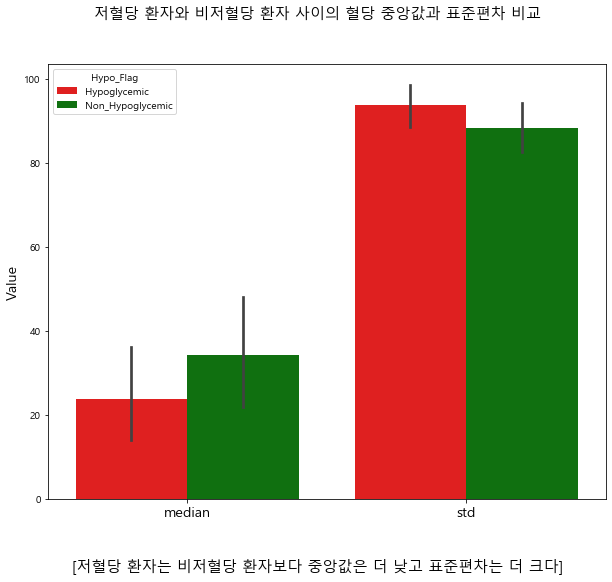

In [103]:
color = ['red','green','orange','blue']

fig = plt.gcf()
plt.suptitle('저혈당 환자와 비저혈당 환자 사이의 혈당 중앙값과 표준편차 비교', fontsize=15)
fig.set_size_inches(10, 8, forward=True)
ax = sns.barplot(x="params", y="value", hue="Hypo_Flag", palette=color,
            data=df_agg_plot.loc[(df_agg_plot['params']  == 'median') |                             
                                 (df_agg_plot['params']  == 'std')])    

ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Value', fontsize=14)
ax.tick_params(axis='x', which='major', labelsize=14)
fig.text(0.5, 0,'[저혈당 환자는 비저혈당 환자보다 중앙값은 더 낮고 표준편차는 더 크다]',
     horizontalalignment='center',
     verticalalignment='baseline',
     size=15)

plt.show()

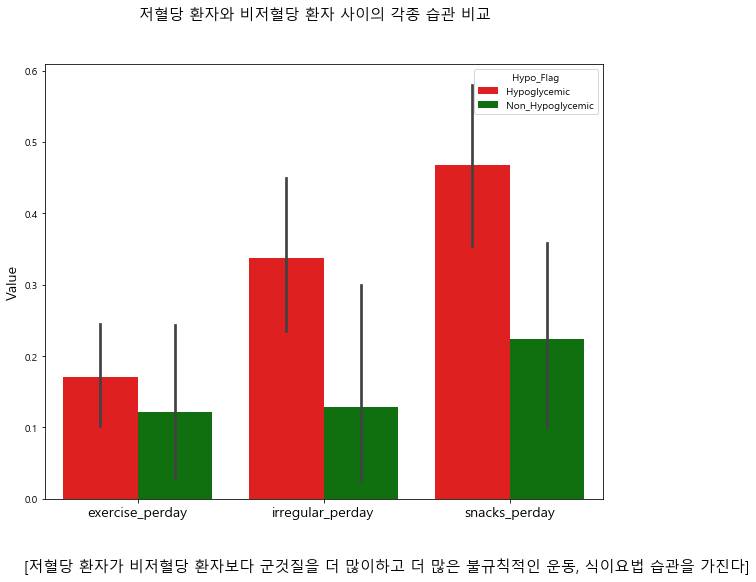

In [104]:
fig = plt.gcf()
plt.suptitle('저혈당 환자와 비저혈당 환자 사이의 각종 습관 비교', fontsize=15)
fig.set_size_inches(10, 8, forward=True)
ax = sns.barplot(x="params", y="value", hue="Hypo_Flag", palette=color,
            data=df_agg_plot.loc[(df_agg_plot['params']  == 'exercise_perday') |                             
                                 (df_agg_plot['params']  == 'irregular_perday') | 
                                 (df_agg_plot['params']  == 'snacks_perday')])    

ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Value', fontsize=14)
ax.tick_params(axis='x', which='major', labelsize=14)
fig.text(0.6, 0,'[저혈당 환자가 비저혈당 환자보다 군것질을 더 많이하고 더 많은 불규칙적인 운동, 식이요법 습관을 가진다]',
     horizontalalignment='center',
     verticalalignment='baseline',
     size=15)

plt.show()

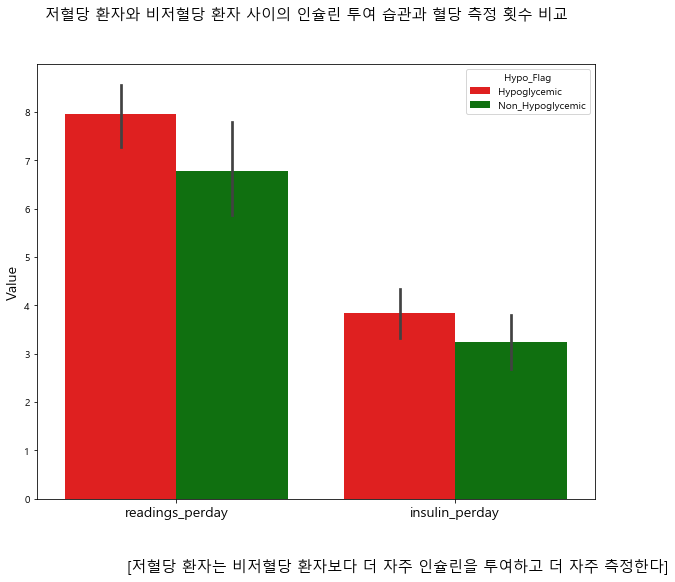

In [105]:
fig = plt.gcf()
fig.set_size_inches(10, 8, forward=True)
fig.suptitle('저혈당 환자와 비저혈당 환자 사이의 인슐린 투여 습관과 혈당 측정 횟수 비교', fontsize=15)
ax = sns.barplot(x="params", y="value", hue="Hypo_Flag", palette=color,
                 data=df_agg_plot.loc[(df_agg_plot['params']  == 'readings_perday') | 
                                      (df_agg_plot['params']  == 'insulin_perday')])    
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Value', fontsize=14)
ax.tick_params(axis='x', which='major', labelsize=14)

fig.text(0.25, 0, '[저혈당 환자는 비저혈당 환자보다 더 자주 인슐린을 투여하고 더 자주 측정한다]', size=15);
plt.show()

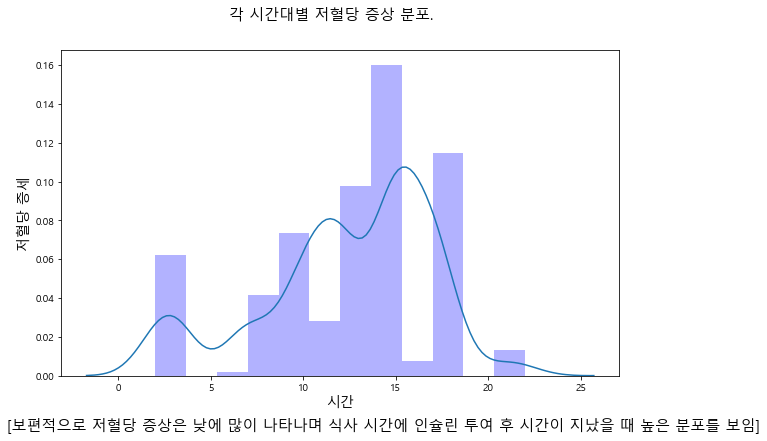

In [106]:
fig = plt.gcf()
fig.set_size_inches(10, 6, forward=True)
fig.suptitle('각 시간대별 저혈당 증상 분포.', fontsize=15)

ax = sns.distplot(df.loc[df['Code_Description']=='HYPOGLYCEMIC_SYMPTOMS', 'Date_Time'].dt.hour, kde=True,bins=12, 
             label='Hypoglycemic', hist_kws={"color": "b", "alpha":0.3}, axlabel='시간')

ax.set_xlabel('시간', fontsize=14)
ax.set_ylabel('저혈당 증세', fontsize=14)

fig.text(0.05, 0, '[보편적으로 저혈당 증상은 낮에 많이 나타나며 식사 시간에 인슐린 투여 후 시간이 지났을 때 높은 분포를 보임]', size=15);
plt.show()